In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.io import loadmat
import os
from scipy.optimize import minimize 

In [2]:
def process(f): 
    d = loadmat(f)['AngSpeed_OrientTIP']
    d[:, 1] = (d[:, 1]-90)/180*np.pi
    return d 

In [77]:
# Run this cell if you want to treat all the swimmers as independent 

path = 'Data/SpinningRodOrientation/'
filenames = [f for f in os.listdir(path) if f.endswith('.mat')] 
Ls = [int(f.split('_')[0][1:])+1 for f in filenames]
Ls, filenames = map(list, zip(*sorted(zip(Ls, filenames))))

data = list(map(process, [path + f for f in filenames]))

agg_data = []
uni_Ls = np.unique(Ls)
for L in uni_Ls: 
    single_length = np.concatenate([d for (d, l) in zip(data, Ls) if l == L])
    agg_data.append(single_length)
Ls = uni_Ls 
data = agg_data 

In [87]:
# Run this cell if we only look at the paired swimmers 

path = 'Data/SpinningRodOrientation/'
filenames = [f for f in os.listdir(path) if f.endswith('2.mat')] 
Ls = [int(f.split('_')[0][1:])+1 for f in filenames] 

## pair up the files 
data = [] 

for f in filenames: 
    p1 = process(path+f) 
    p2 = process(path+f[:-5]+'.mat')

    if len(p1) != len(p2):
        ll = max(len(p1), len(p2))
        if len(p1) < ll: 
            p1 = np.concatenate((p1, p2[len(p1):]))
        else: 
            p2 = np.concatenate((p2, p1[len(p2)-1:]))
    data.append((p1+p2)/2)

# f0 = [f[:-5] + '.mat' for f in filenames]  + filenames 
# filenames_remaining = [f for f in os.listdir(path) if f.endswith('.mat') and not f in f0 ]
# data.extend(list(map(process, [path + f for f in filenames_remaining])))
# Ls.extend([int(f.split('_')[0][1:]) for f in filenames_remaining])

uni_Ls = sorted(np.unique(Ls))
agg_data = []
for L in uni_Ls: 
    single_length = np.concatenate([d for (d, l) in zip(data, Ls) if l == L])
    agg_data.append(single_length)
Ls = uni_Ls 
data = agg_data 

/var/folders/5n/0rvnm9350db7gk5vdnj3tn6h0000gn/T/ipykernel_9926/951533630.py:10: RuntimeWarning: divide by zero encountered in log
  axs[1].plot(mids, -np.log(counts), 'o--', label='L={}'.format(Ls[i]), color=plt.cm.tab10(i))
/var/folders/5n/0rvnm9350db7gk5vdnj3tn6h0000gn/T/ipykernel_9926/951533630.py:11: RuntimeWarning: divide by zero encountered in log
  Vs.append(-np.log(counts))


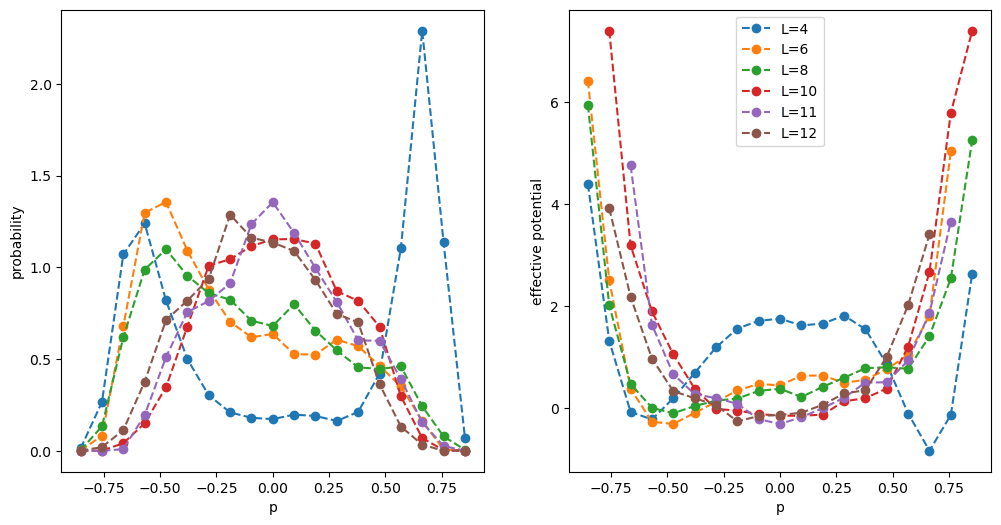

In [95]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
N = 19
bins = np.linspace(-0.9, 0.9, N+1)
mids = np.array([(x+y)/2 for (x, y) in zip(bins[:-1], bins[1:])])
Vs = [] 
Ps = [] 
for i in range(len(Ls)):
    counts, _ = np.histogram(np.sin(data[i][:, 1]), bins=bins, density=True)
    axs[0].plot(mids, counts, 'o--', color=plt.cm.tab10(i))
    axs[1].plot(mids, -np.log(counts), 'o--', label='L={}'.format(Ls[i]), color=plt.cm.tab10(i))
    Vs.append(-np.log(counts))
    Ps.append(counts)
axs[0].set_xlabel('p')
axs[0].set_ylabel('probability')
axs[1].set_xlabel('p')
axs[1].set_ylabel('effective potential')
plt.legend()
plt.show() 

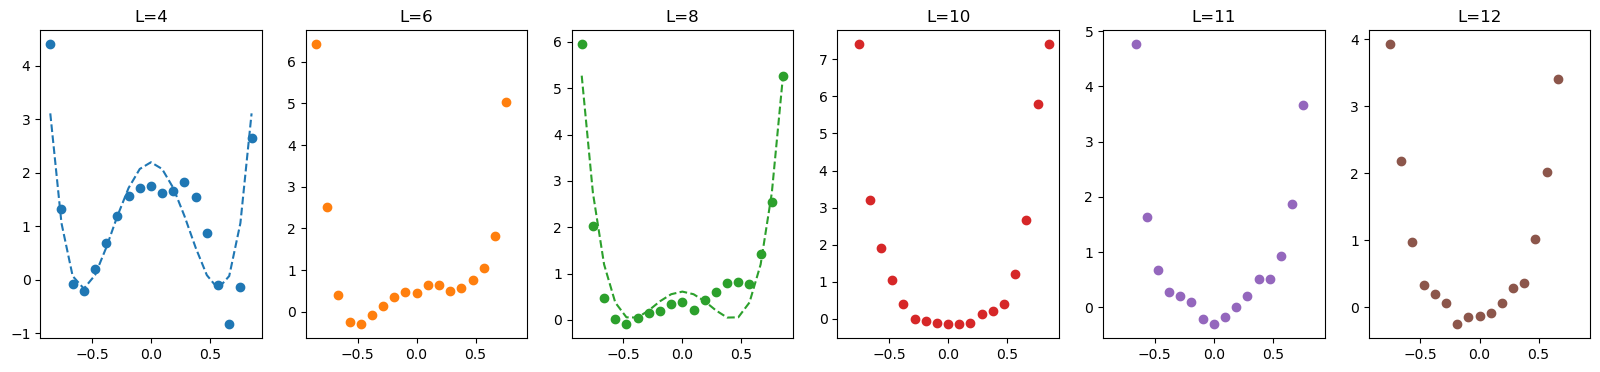

[[ 21.18683257 -14.14692001   2.19552675]
 [         nan          nan          nan]
 [ 17.6773745   -6.43932061   0.6108361 ]
 [         nan          nan          nan]
 [         nan          nan          nan]
 [         nan          nan          nan]]


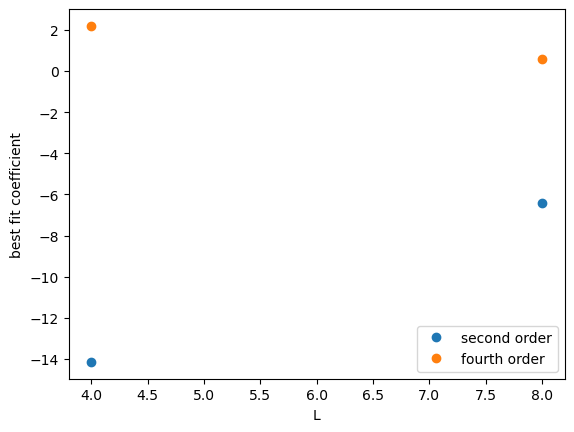

In [90]:
zs = [] 
fig, axes = plt.subplots(1, len(Ls), sharex=True, figsize=(20, 4))

for i in range(len(Ls)):
    z = np.polyfit(mids**2, Vs[i], deg=2)
    p = np.poly1d(z)
    axes[i].plot(mids, Vs[i], 'o', c=plt.cm.tab10(i))
    axes[i].plot(mids, p(mids**2), '--', c=plt.cm.tab10(i))
    axes[i].set_title('L={}'.format(Ls[i]))
    zs.append(z)
plt.show() 

zs = np.array(zs)
print(zs)

plt.plot(Ls, zs[:, 1], 'o', label='second order')
plt.plot(Ls, zs[:, 2], 'o', label='fourth order')
plt.xlabel('L')
plt.ylabel('best fit coefficient')
plt.legend()
plt.show() 

In [91]:
Vs = np.array(Vs)
Ps = np.array(Ps)
Rs = np.array(Ls)/2
mids = np.array(mids)
print(Ps.shape)

def get_V(params): 
    V = ( 0.5*np.outer((params[0] - params[1]/Rs), mids**2) +  
             0.25*params[2]*(mids**4)[np.newaxis, :])
    Z = np.sum(np.exp(-V), axis=-1)*(mids[1]-mids[0])
    V += np.log(Z)[:, np.newaxis]
    return V 
    
def cost(params): 
    # quadratic cost function
    # params in order of gamma, a, b 
    V_fit = get_V(params)
    return np.sum(V_fit*Ps)

guess = [1, 1, 1]
bounds = [[0, None]]*3
res = minimize(cost, guess, bounds=bounds, method='trust-constr')

(6, 19)


[10.83812094 69.31100498 60.35907225] 17.375591428888885


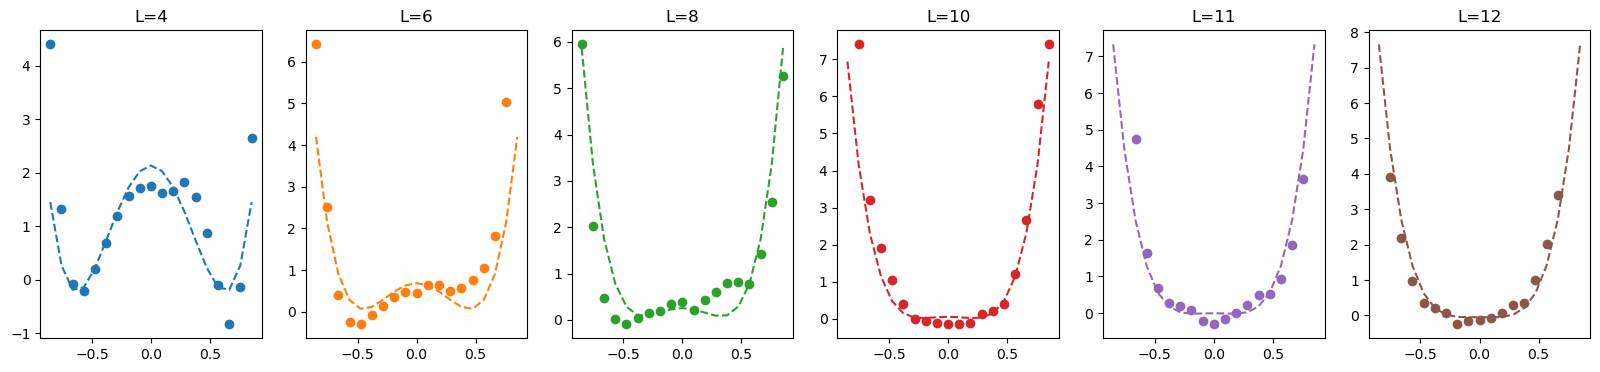

In [92]:
print(res.x, res.fun)
V_fit = get_V(res.x)

fig, axes = plt.subplots(1, len(Ls), sharex=True, figsize=(20, 4))
for (i, L) in enumerate(Ls): 
    axes[i].plot(mids, Vs[i], 'o', c=plt.cm.tab10(i))
    axes[i].plot(mids, V_fit[i], '--', c=plt.cm.tab10(i))
    axes[i].set_title('L={}'.format(L))
plt.show()

In [93]:
# Bin the negative and positive data together 

Ps_sym = Ps[:, int((N)/2):] + np.flip(Ps[:, :int((N)/2)+1], axis=1)
mids_sym = mids[int((N)/2):]

def get_V(params): 
    V = ( 0.5*np.outer((params[0] - params[1]/Rs), mids_sym**2) +  
             0.25*params[2]*(mids_sym**4)[np.newaxis, :])
    Z = np.sum(np.exp(-V), axis=-1)*(mids_sym[1]-mids_sym[0])
    V += np.log(Z)[:, np.newaxis]
    return V 


def cost(params): 
    # quadratic cost function
    # params in order of gamma, a, b 
    V_fit = get_V(params)
    return np.sum(V_fit*Ps_sym)

guess = [1, 1, 1]
bounds = [[0, None]]*3
res = minimize(cost, guess, bounds=bounds, method='trust-constr')


[11.20856332 68.88091225 58.86983389] -24.47350648855422


/var/folders/5n/0rvnm9350db7gk5vdnj3tn6h0000gn/T/ipykernel_9926/2663310423.py:6: RuntimeWarning: divide by zero encountered in log
  axes[i].plot(mids_sym, -np.log(Ps_sym[i]), 'o', c=plt.cm.tab10(i))


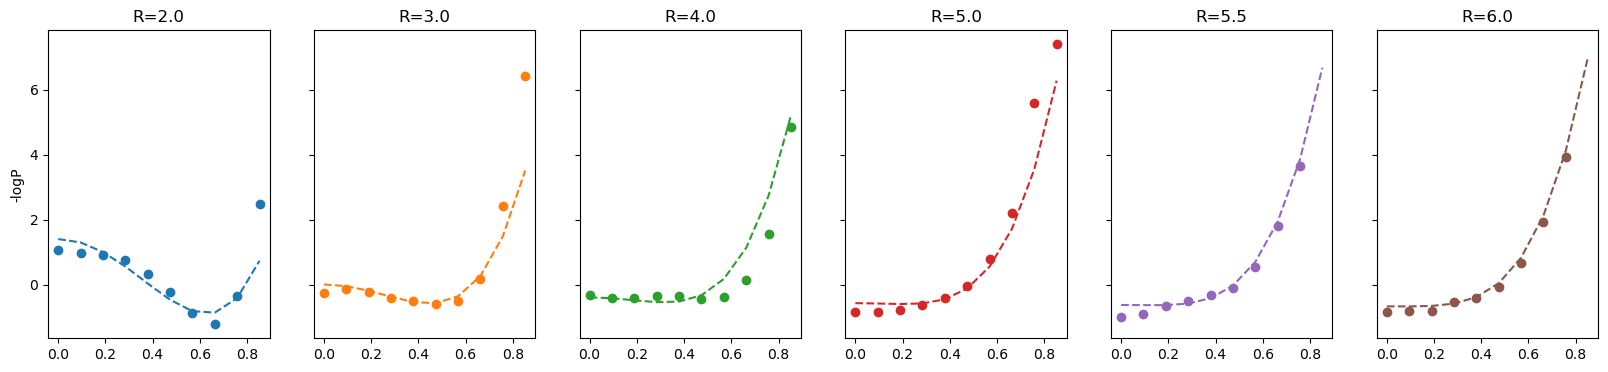

In [97]:
print(res.x, res.fun)
V_fit = get_V(res.x)

fig, axes = plt.subplots(1, len(Ls), sharex=True, sharey=True, figsize=(20, 4))
for (i, L) in enumerate(Ls): 
    axes[i].plot(mids_sym, -np.log(Ps_sym[i]), 'o', c=plt.cm.tab10(i))
    axes[i].plot(mids_sym, V_fit[i], '--', c=plt.cm.tab10(i))
    axes[i].set_title('R={}'.format(L/2))
axes[0].set_ylabel('-logP')
plt.show()

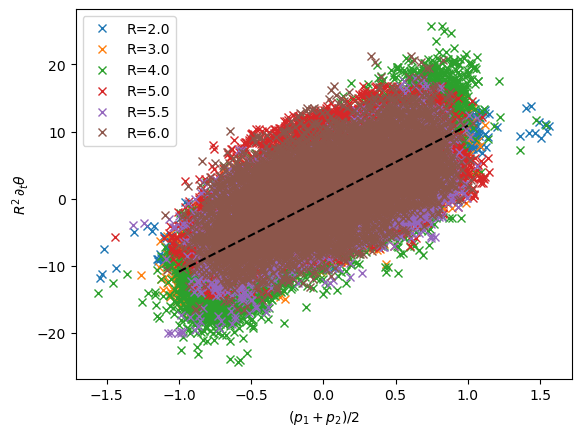

10.868832739602876 0.015106583659794262


In [84]:
x = [] 
y = [] 

for (d, L) in zip(data, Ls): 
    plt.plot(d[:, 1], d[:, 0]*L*L/4, 'x', label='R={}'.format(L/2))
    x.extend(d[:, 1]) 
    y.extend(d[:, 0]*L*L/4)
plt.legend()
plt.ylabel(r'$R^2 \, \partial_t \theta$')
plt.xlabel('$(p_1 + p_2)/2$')

m, b = np.polyfit(x, y, 1)
X = np.linspace(-1, 1, 100)
plt.plot(X, m*X+b, '--k')
plt.show()

print(m, b)

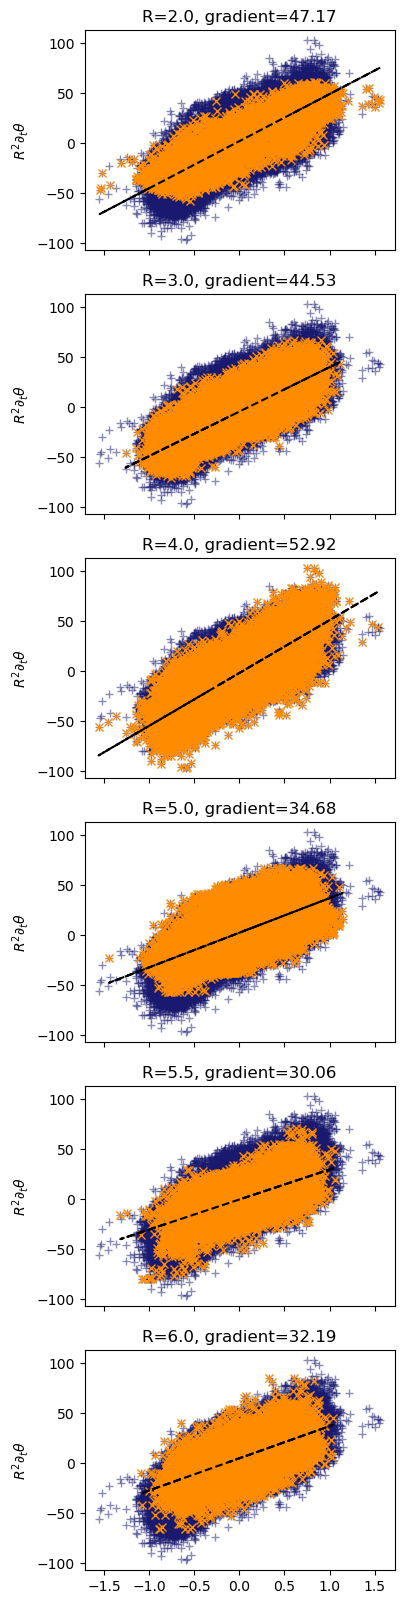

In [85]:
ms = [] 

fig, axes = plt.subplots(len(data), 1, figsize=(4, 20), sharex=True, sharey=True)

for (i, (d, L)) in enumerate(zip(data, Ls)): 
    for (d2, L2) in zip(data, Ls):  
        axes[i].plot(d2[:, 1], d2[:, 0]*L2**2, '+', alpha=0.5, color='midnightblue')
        
    y = d[:, 0]*L**2
    x = d[:, 1]
    axes[i].plot(x, y, 'x', color='darkorange')
    m, b = np.polyfit(x, y, 1)
    ms.append(m)

    axes[i].plot(x, m*x+b, '--k')
    axes[i].set_title('R={}, gradient={:.2f}'.format(L/2, m))
    axes[i].set_ylabel(r'$R^2 \partial_t \theta$')
plt.show() 

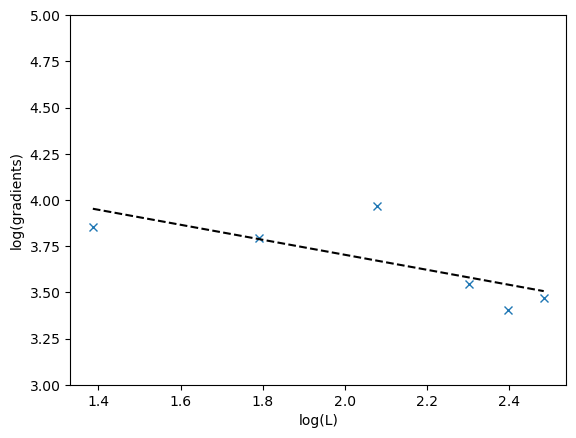

gradient =  -0.4057007911987211


In [86]:
m, b = np.polyfit(np.log(Ls), np.log(ms), 1)

plt.plot(np.log(Ls), np.log(ms), 'x')
plt.plot(np.log(Ls), m*np.log(Ls)+b, 'k--')
# plt.xlim([1, 2.5])
plt.ylim([3, 5])
plt.xlabel('log(L)')
plt.ylabel('log(gradients)')
plt.show() 

print('gradient = ', m)